In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/archive_4.zip', sep=',')

# View basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1048575 non-null  object 
 1   Time                   1048575 non-null  object 
 2   Global_active_power    1048575 non-null  object 
 3   Global_reactive_power  1048575 non-null  object 
 4   Voltage                1048575 non-null  object 
 5   Global_intensity       1048575 non-null  object 
 6   Sub_metering_1         1048575 non-null  object 
 7   Sub_metering_2         1048575 non-null  object 
 8   Sub_metering_3         1044506 non-null  float64
dtypes: float64(1), object(8)
memory usage: 72.0+ MB
None
         Date      Time Global_active_power Global_reactive_power Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.84   
1  16/12/2006  17:25:00                5.36                 0.436  233.63   
2  16

In [10]:
import pandas as pd

# Load CSV
df = pd.read_csv('/content/archive_4.zip', sep=',', na_values='?')

# Combine 'date' and 'time' into one datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set datetime as index
df.set_index('datetime', inplace=True)

# Drop original 'date' and 'time'
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Convert target column to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Now resample correctly (use lowercase 'h' instead of deprecated 'H')
df_power_hourly = df[['Global_active_power']].resample('h').mean()

# Fill missing values
df_power_hourly.fillna(method='ffill', inplace=True)

# Confirm
print(df_power_hourly.head())


                     Global_active_power
datetime                                
2006-12-16 17:00:00             4.222889
2006-12-16 18:00:00             3.632200
2006-12-16 19:00:00             3.400233
2006-12-16 20:00:00             3.268567
2006-12-16 21:00:00             3.056467


/tmp/ipython-input-10-1746945123.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
/tmp/ipython-input-10-1746945123.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_power_hourly.fillna(method='ffill', inplace=True)


In [11]:
df_power_hourly['hour'] = df_power_hourly.index.hour
df_power_hourly['dayofweek'] = df_power_hourly.index.dayofweek
df_power_hourly['is_weekend'] = (df_power_hourly['dayofweek'] >= 5).astype(int)


In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train-test split
train = df_power_hourly['Global_active_power'][:-168]  # last 7 days for test
test = df_power_hourly['Global_active_power'][-168:]

# Fit ARIMA
model_arima = ARIMA(train, order=(2,1,2))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=168)

# Evaluation
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
print(f"ARIMA - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA - MAE: 0.76, RMSE: 0.92


In [13]:
!pip install prophet --quiet

from prophet import Prophet

df_prophet = df_power_hourly.reset_index()[['datetime', 'Global_active_power']].rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})
train_prophet = df_prophet[:-168]
test_prophet = df_prophet[-168:]

model_prophet = Prophet()
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=168, freq='H')
forecast_prophet = model_prophet.predict(future)

# Evaluation
y_true = test_prophet['y'].values
y_pred = forecast_prophet['yhat'][-168:].values
mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Prophet - MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjqn1nib_/pbt7zwtt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjqn1nib_/g1o1j2rv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21500', 'data', 'file=/tmp/tmpjqn1nib_/pbt7zwtt.json', 'init=/tmp/tmpjqn1nib_/g1o1j2rv.json', 'output', 'file=/tmp/tmpjqn1nib_/prophet_modelldmywbpi/prophet_model-20250703101605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version

Prophet - MAE: 0.56, RMSE: 0.73


In [14]:
!pip install xgboost --quiet
import xgboost as xgb

# Prepare features
df_ml = df_power_hourly.dropna().copy()
features = ['hour', 'dayofweek', 'is_weekend']
target = 'Global_active_power'

X = df_ml[features]
y = df_ml[target]

# Train-test split
X_train, X_test = X[:-168], X[-168:]
y_train, y_test = y[:-168], y[-168:]

# Fit model
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")


XGBoost - MAE: 0.52, RMSE: 0.72


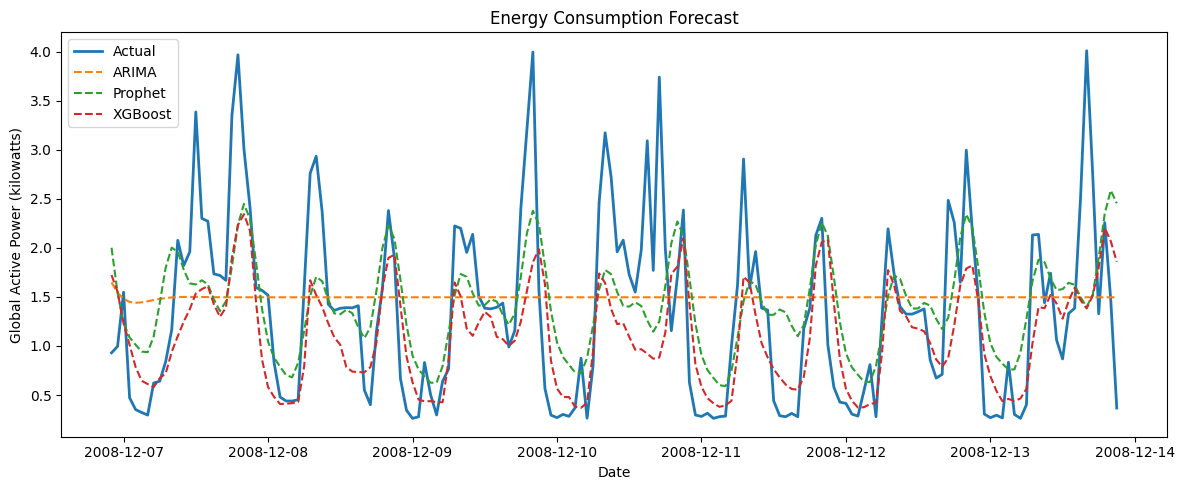

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label='Actual', linewidth=2)
plt.plot(test.index, forecast_arima, label='ARIMA', linestyle='--')
plt.plot(test.index, y_pred, label='Prophet', linestyle='--')
plt.plot(test.index, y_pred_xgb, label='XGBoost', linestyle='--')
plt.title('Energy Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.tight_layout()
plt.show()
